                CPI  MoM_Inflation  YoY_Inflation
Date                                             
2021-01-01  261.582            NaN            NaN
2021-02-01  263.014       0.547438            NaN
2021-03-01  264.877       0.708327            NaN
2021-04-01  267.054       0.821891            NaN
2021-05-01  269.195       0.801711            NaN
2021-06-01  271.696       0.929066            NaN
2021-07-01  273.003       0.481052            NaN
2021-08-01  273.567       0.206591            NaN
2021-09-01  274.310       0.271597            NaN
2021-10-01  276.589       0.830812            NaN
2021-11-01  277.948       0.491343            NaN
2021-12-01  278.802       0.307252            NaN
2022-01-01  281.148       0.841457       7.479872
2022-02-01  283.716       0.913398       7.871064
2022-03-01  287.504       1.335138       8.542456
2022-04-01  289.109       0.558253       8.258629
2022-05-01  292.296       1.102352       8.581512
2022-06-01  296.311       1.373608       9.059758


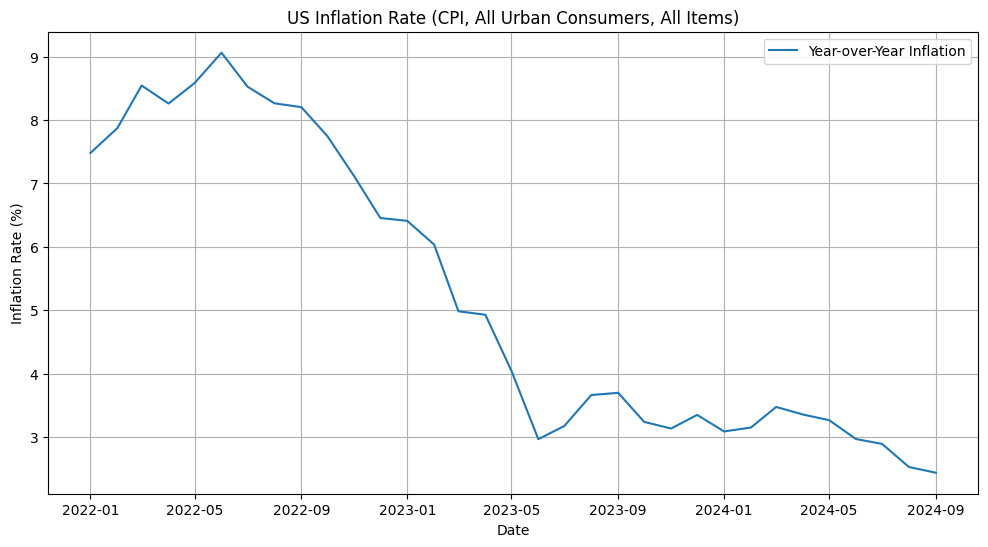

In [13]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# BLS API endpoint
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# Series ID for CPI (All Urban Consumers, All Items, Not Seasonally Adjusted)
series_id = 'CUUR0000SA0'

# API request parameters
data = json.dumps({
    "seriesid": [series_id],
    "startyear": "2021",
    "endyear": "2024",
    "registrationkey": "d7ba76b4ba7b4f0fbec2d1d704a819d1"  # Replace with your BLS API key
})

# Send request to BLS API
headers = {'Content-type': 'application/json'}
response = requests.post(url, data=data, headers=headers)

# Parse the JSON response
json_data = json.loads(response.text)

# Extract the data series
series = json_data['Results']['series'][0]

# Create a list of dictionaries with the data
data_list = []
for item in series['data']:
    year = int(item['year'])
    month = int(item['period'][1:])  # Remove 'M' prefix from month
    date = datetime(year, month, 1)
    value = float(item['value'])
    data_list.append({'Date': date, 'CPI': value})

# Create a DataFrame
df = pd.DataFrame(data_list)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Calculate month-over-month inflation rate
df['MoM_Inflation'] = df['CPI'].pct_change() * 100

# Calculate year-over-year inflation rate
df['YoY_Inflation'] = df['CPI'].pct_change(periods=12) * 100

# Display the data
print(df)

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['YoY_Inflation'], label='Year-over-Year Inflation')
plt.title('US Inflation Rate (CPI, All Urban Consumers, All Items)')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()
